# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_3m_0f_240214_3"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [70, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 36000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,535.297262,30.836375,535.323500,30.833289,0.0,565.000000,8.000000,0.588235,572.000000,16.000000,-1.382327,1534.0,100.422905,24.252911,0.970399,7
1,1,0,1738.798193,131.415663,1739.549044,138.920917,NaN,1738.798193,131.415663,NaN,1738.798193,131.415663,0.265600,332.0,298.442889,61.199195,0.978749,7
2,2,0,1708.229911,117.338472,1707.978477,117.708541,0.0,1702.000000,56.000000,0.168627,1680.000000,88.000000,0.157562,6098.0,120.433016,78.042325,0.761628,7
3,3,0,1719.159080,243.979442,1715.728756,244.655714,NaN,1719.159080,243.979442,NaN,1719.159080,243.979442,0.401342,2043.0,94.325281,62.586053,0.748165,7
4,4,0,1101.301167,1009.758075,1098.503485,1007.652490,0.0,1020.000000,962.000000,0.741176,1069.000000,1043.000000,1.393966,12508.0,246.097324,87.498857,0.934659,7
5,5,0,722.803217,1014.625220,727.750925,1012.168692,0.0,894.000000,963.000000,0.956863,686.000000,984.000000,1.451087,7399.0,167.167828,79.452743,0.879831,7


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([2, 4, 5])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         7   535.297262    30.836375    -1.382327
1   1     0         7  1738.798193   131.415663     0.265600
2   2     0         7  1708.229911   117.338472     0.157562
3   3     0         7  1719.159080   243.979442     0.401342
4   4     0         7  1101.301167  1009.758075     1.393966
5   5     0         7   722.803217  1014.625220     1.451087
6   6     0         7  1541.602878  1051.820144     1.409052


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
2,0,0,1708.229911,117.338472,1707.978477,117.708541,0.0,1702.000000,56.000000,0.168627,1680.000000,88.000000,0.157562,6098.0,120.433016,78.042325,0.761628,7
4,1,0,1101.301167,1009.758075,1098.503485,1007.652490,0.0,1020.000000,962.000000,0.741176,1069.000000,1043.000000,-1.393966,12508.0,246.097324,87.498857,0.934659,7
5,2,0,722.803217,1014.625220,727.750925,1012.168692,0.0,894.000000,963.000000,0.956863,686.000000,984.000000,1.451087,7399.0,167.167828,79.452743,0.879831,7
7,0,3,746.081201,4.695217,746.150532,4.709088,NaN,746.081201,4.695217,NaN,746.081201,4.695217,-1.567494,899.0,99.283392,15.439917,0.987834,7
8,1,3,535.631914,30.729180,535.647637,30.720527,0.0,561.000000,7.000000,0.588235,567.000000,15.000000,-1.394445,1573.0,102.116647,25.422653,0.968515,7
9,2,3,1739.006154,133.218462,1739.714777,140.767918,NaN,1739.006154,133.218462,NaN,1739.006154,133.218462,0.266593,325.0,299.298880,61.592962,0.978596,7
10,3,3,1708.143519,116.842245,1707.904071,117.186964,0.0,1702.000000,56.000000,0.168627,1682.000000,82.000000,0.167683,6041.0,119.823306,78.032631,0.758880,7


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
13376,1,35997,1705.588723,126.544432,1704.105341,124.223557,0.0,1692.0,49.0,0.427451,1726.0,99.0,0.320780,7112.0,149.542888,70.560683,0.881683,6
13377,2,35997,906.838720,952.031402,901.977410,943.623163,0.0,850.0,831.0,0.784314,933.0,974.0,0.567577,15222.0,261.510156,87.145151,0.942843,6
13378,3,35997,612.976342,1010.562798,624.170688,1008.475497,0.0,667.0,950.0,0.713725,650.0,975.0,1.570435,12596.0,234.905206,86.269191,0.930122,6
13379,4,35997,1641.298999,1053.132386,1640.194970,1053.455771,0.0,1737.0,1033.0,0.494118,1606.0,1059.0,-1.395568,3097.0,188.720118,43.359810,0.973248,6
13380,5,35997,240.543609,1060.925188,241.315697,1060.878045,0.0,204.0,1049.0,0.588235,264.0,1052.0,-1.491537,2660.0,174.196229,29.822313,0.985236,6


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


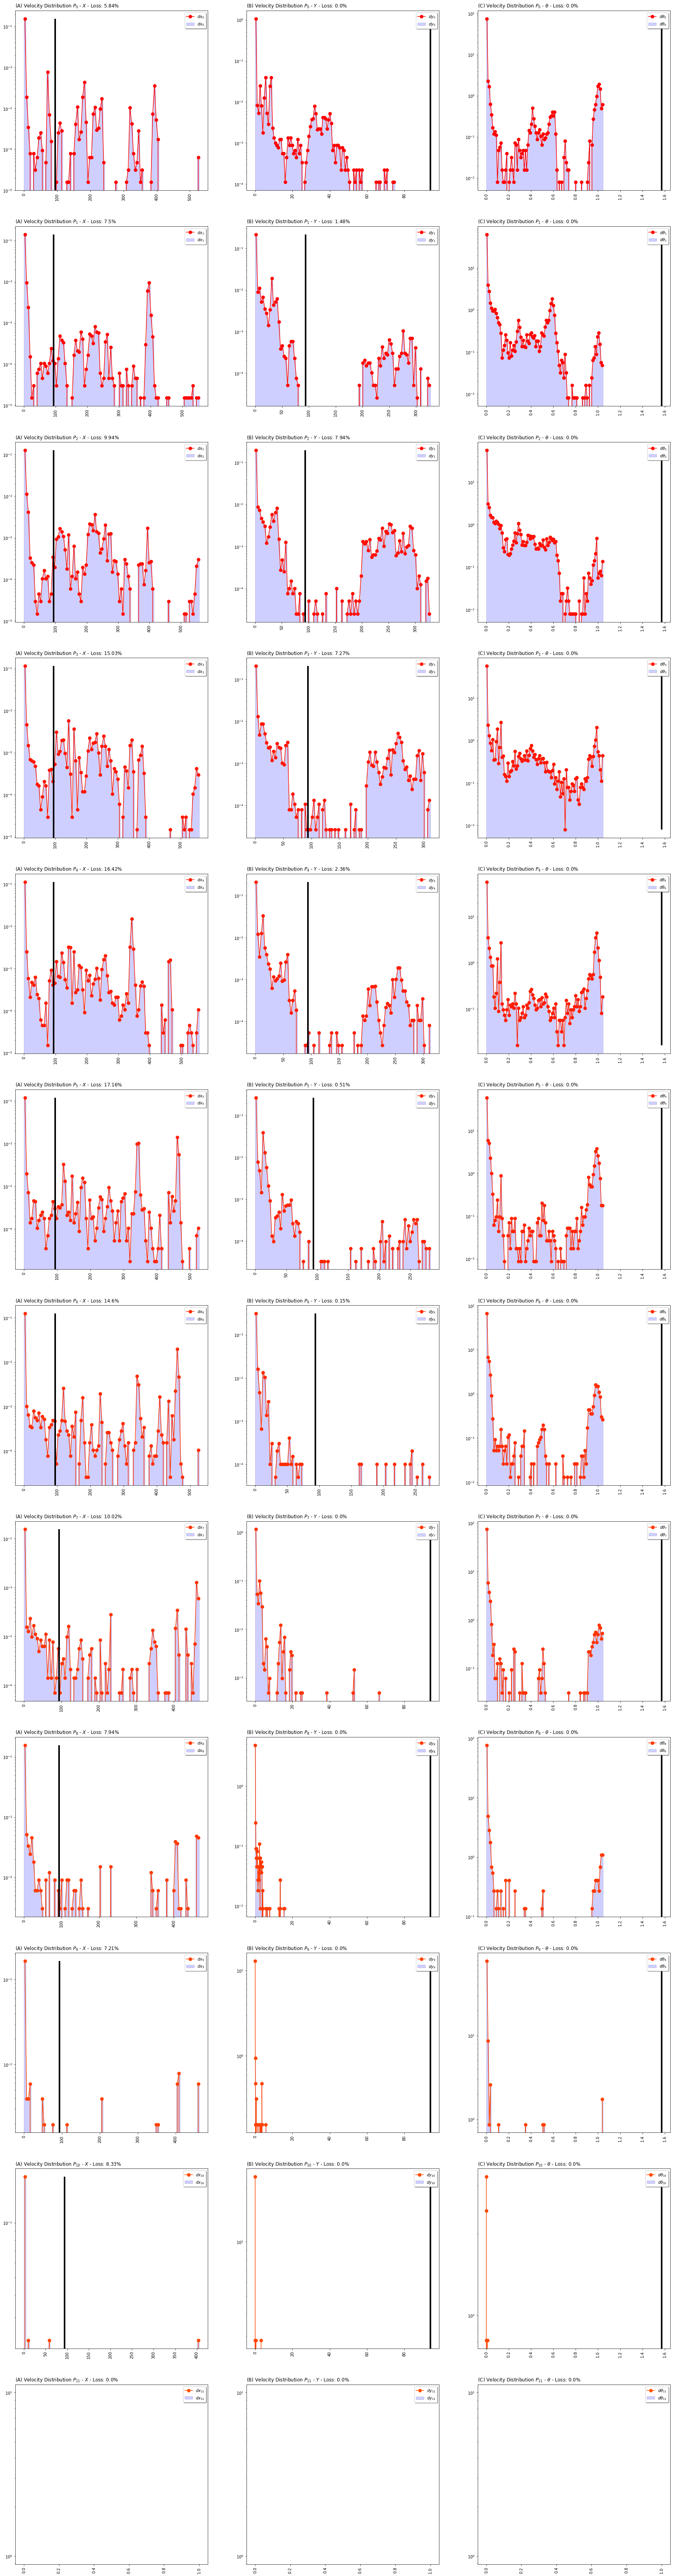

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,4,480
1,5,5340
2,6,21270
3,7,29550
4,8,18720
5,9,5346
6,10,990
7,11,121
8,12,12


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 56.889222284483424 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,4,False,False,False,0.448496
1,4,False,True,False,0.061103
2,4,True,False,False,0.075768
3,4,True,True,False,0.001222
4,5,False,False,False,5.401508
5,5,False,True,False,0.428943
6,5,True,False,False,0.675800
7,5,True,True,False,0.019553
8,6,False,False,False,22.583681
9,6,False,True,False,1.109631


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 175.3444989816593 
	- Angle: 56.889222284483424 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 0.013888888888888888%
Final loss data Y-axis: 0.013888888888888888%
Final loss data Angle : 0.008333333333333333%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.008333
1,3,False,False,True,0.005556
2,3,True,True,True,99.986111


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 175.3444989816593 
	- Angle: 56.889222284483424 



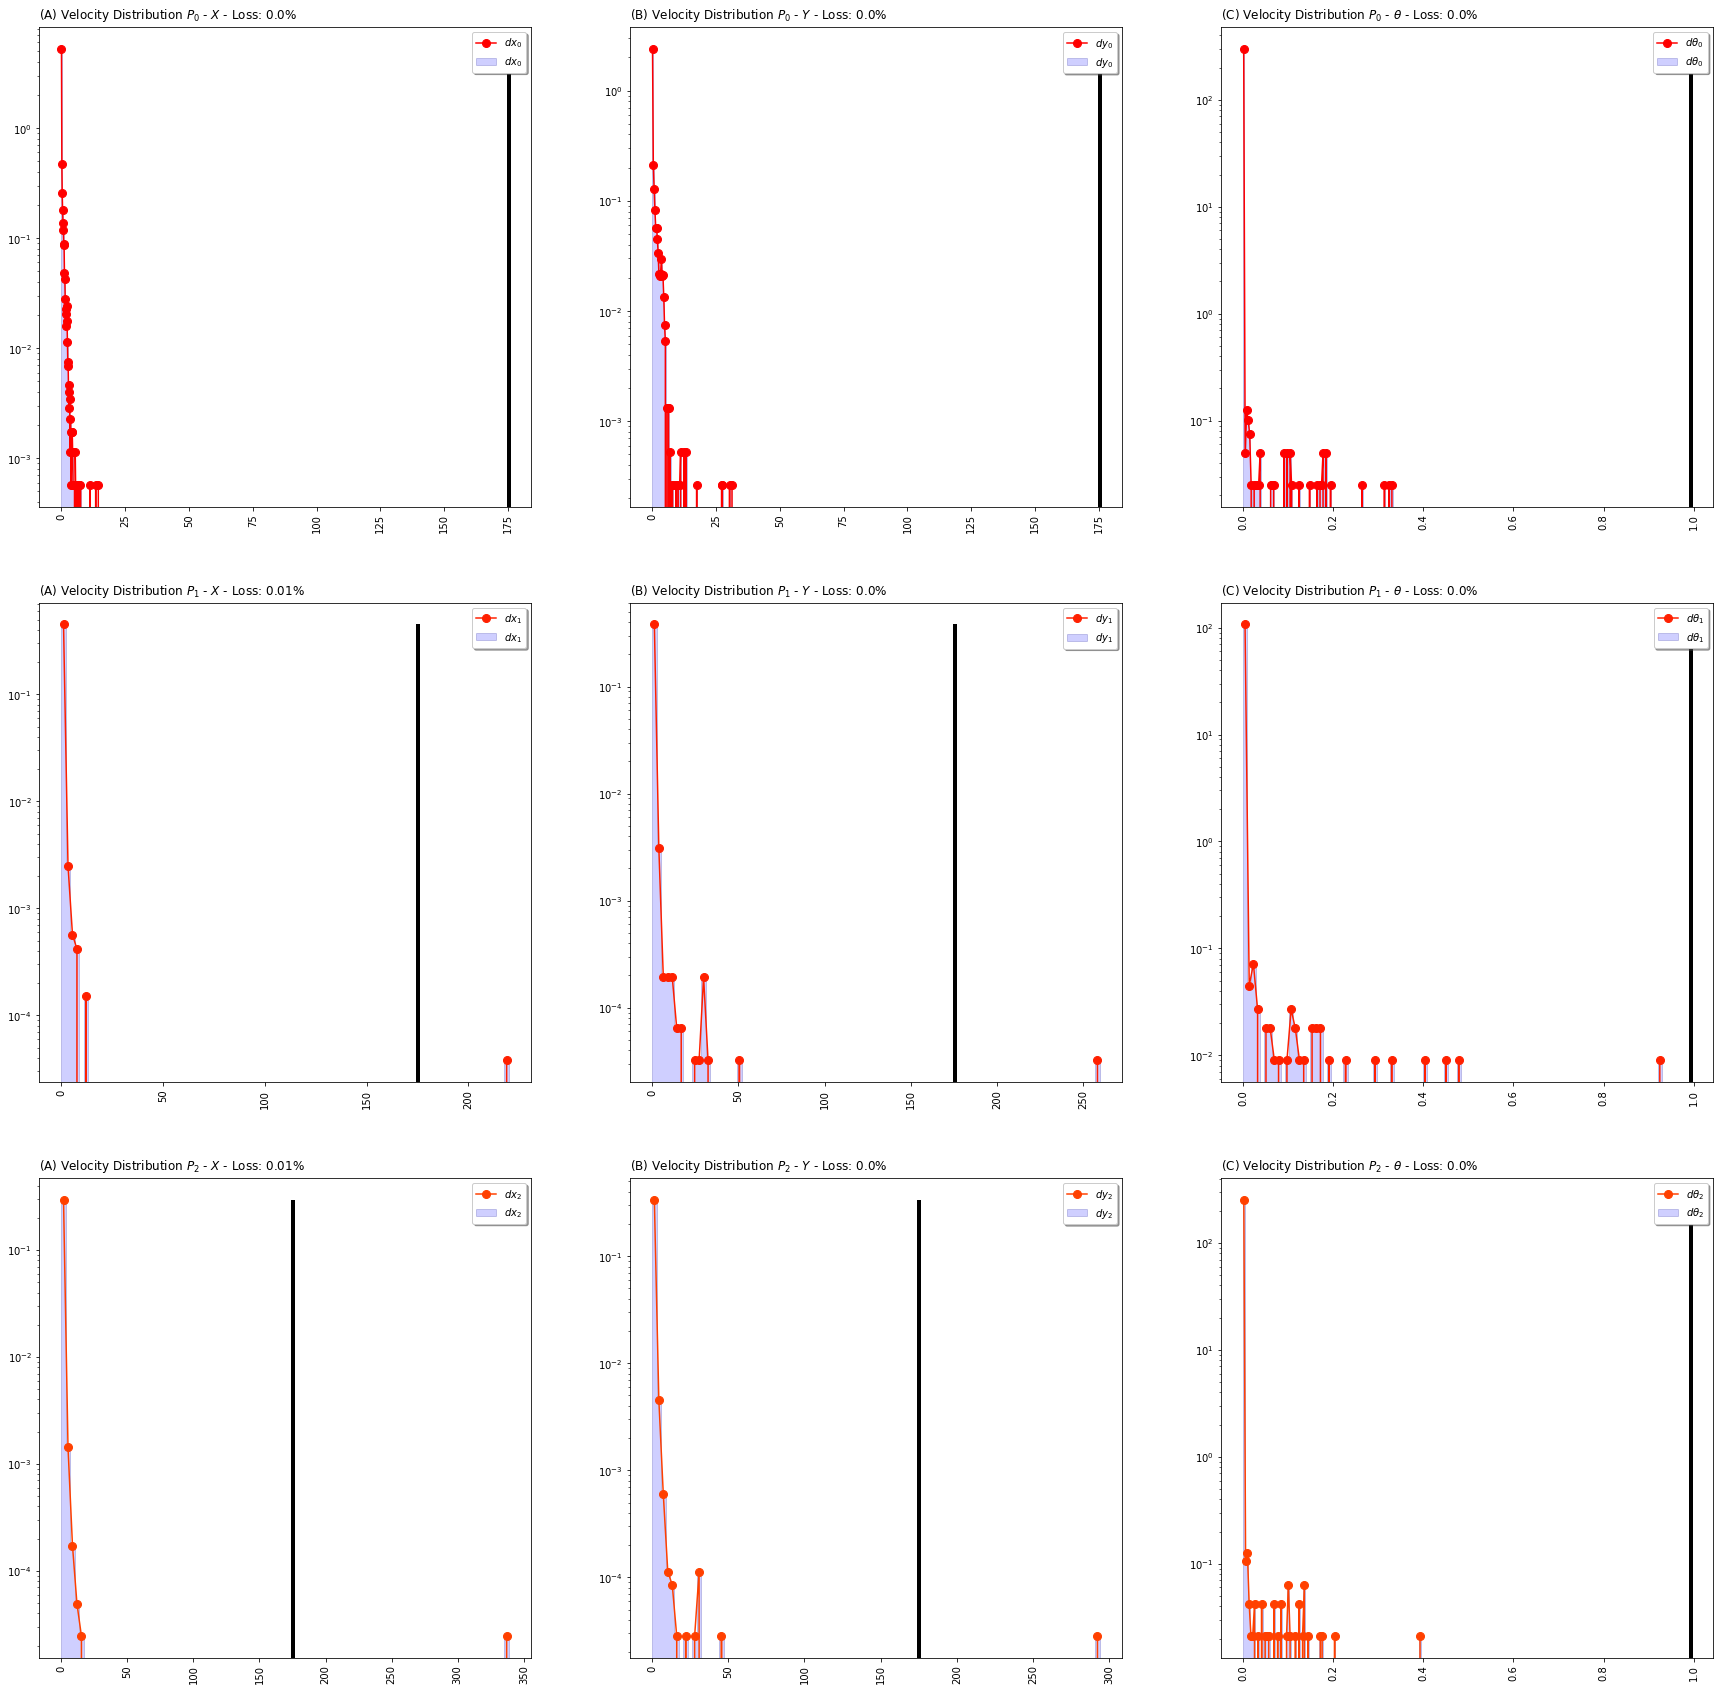

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1708.229911,117.338472,1707.978477,117.708541,0.0,1702.000000,56.000000,0.168627,1680.000000,88.000000,0.157562,6098.0,120.433016,78.042325,0.761628,3,NaN,NaN,NaN,NaN,False,False,False
1,1,0,1101.301167,1009.758075,1098.503485,1007.652490,0.0,1020.000000,962.000000,0.741176,1069.000000,1043.000000,-1.393966,12508.0,246.097324,87.498857,0.934659,3,NaN,NaN,NaN,NaN,False,False,False
2,2,0,722.803217,1014.625220,727.750925,1012.168692,0.0,894.000000,963.000000,0.956863,686.000000,984.000000,1.451087,7399.0,167.167828,79.452743,0.879831,3,NaN,NaN,NaN,NaN,False,False,False
4,0,3,1708.143519,116.842245,1707.904071,117.186964,0.0,1702.000000,56.000000,0.168627,1682.000000,82.000000,0.167683,6041.0,119.823306,78.032631,0.758880,3,3.0,-0.028797,-0.165409,0.003373,False,False,False
5,1,3,1101.728925,1009.863739,1099.400060,1007.859234,0.0,998.000000,963.000000,0.741176,1169.000000,1040.000000,1.394260,12432.0,243.918959,87.489889,0.933459,3,3.0,0.142586,0.035221,0.929409,False,False,False
3,2,3,1739.006154,133.218462,1739.714777,140.767918,NaN,1739.006154,133.218462,NaN,1739.006154,133.218462,0.266593,325.0,299.298880,61.592962,0.978596,3,3.0,338.734312,-293.802253,-0.394831,True,False,False
7,0,6,1708.161535,116.865622,1707.923487,117.213028,0.0,1702.000000,56.000000,0.168627,1682.000000,82.000000,0.167683,6041.0,119.823306,78.032631,0.758880,3,3.0,0.006005,0.007792,0.000000,False,False,False
8,1,6,1101.728925,1009.863739,1099.400060,1007.859234,0.0,998.000000,963.000000,0.741176,1169.000000,1040.000000,1.394260,12432.0,243.918959,87.489889,0.933459,3,3.0,0.000000,0.000000,0.000000,False,False,False
6,2,6,1738.975804,132.765291,1739.665393,140.197640,NaN,1738.975804,132.765291,NaN,1738.975804,132.765291,0.266593,325.0,299.298880,61.592962,0.978596,3,3.0,-0.010117,-0.151057,0.000000,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_3m_0f_240214_3_c.zip'